<a href="https://colab.research.google.com/github/Noah-To/AIAB/blob/main/CW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install gymnasium pyvirtualdisplay torch matplotlib numpy tqdm
%pip install "gymnasium[classic-control]"

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from multiprocessing import Pool
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
def plot_fitness_curve(x_vals, y_vals):
    plt.figure(figsize=(9, 5))
    x = np.array(x_vals)
    y = np.array(y_vals)
    mask = np.isfinite(y)
    x_clean = x[mask]
    y_clean = y[mask]
    x_smooth = np.linspace(min(x_clean), max(x_clean), 500)

    plt.scatter(x_clean, y_clean, s=1, alpha=0.2, color='gray', label="Raw Data")
    try:
        model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
        model.fit(x_clean.reshape(-1, 1), y_clean)
        y_poly = model.predict(x_smooth.reshape(-1, 1))
        plt.plot(x_smooth, y_poly, 'g-', linewidth=2, label="Cubic Polynomial")
    except Exception as e:
        print(f"Polynomial regression failed: {e}")

    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.ylim(-300, 700)
    plt.title("Polynomial Regression")
    plt.legend()
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

def fitness_worker(genotype):
    env = gym.make("CartPole-v1")
    total = 0
    obs, _ = env.reset()
    for _ in range(500):
        weights = genotype[:-2].reshape(2, 4)
        bias = genotype[-2:]
        logits = np.dot(weights, obs) + bias
        action = np.argmax(logits)
        obs, reward, terminated, truncated, _ = env.step(action)
        total += reward
        if terminated or truncated:
            break
    env.close()
    return total

In [ ]:
class GA:

    def __init__(self, pop_size, generations):
        self.pop_size = pop_size
        self.generations = generations
        self.genotype_len = 4 * 2 + 2
        self.mutation_rate = 0.1
        self.crossover_rate = 0.8
        self.tournament_size = 3
        self.pop = np.random.uniform(-1, 1, (pop_size, self.genotype_len))

    def tournament(self, scores):
        idx = np.random.choice(np.arange(self.pop_size), self.tournament_size, replace=False)
        return self.pop[idx[np.argmax(scores[idx])]].copy()

    def crossover(self, p1, p2):
        if np.random.rand() < self.crossover_rate:
            pt = np.random.randint(1, self.genotype_len)
            return np.concatenate([p1[:pt], p2[pt:]]), np.concatenate([p2[:pt], p1[pt:]])
        return p1.copy(), p2.copy()

    def mutate(self, g):
        for i in range(len(g)):
            if np.random.rand() < self.mutation_rate:
                g[i] += np.random.normal(0, 0.1)
        return g
# uses 160 CPUs to run to increase efficiency.
    def evolve(self, num_workers=160):
        from multiprocessing import Pool

        best = None
        best_score = -np.inf
        all_fitness_records = []
        history = []

        with Pool(processes=num_workers) as pool:
            for gen in tqdm(range(self.generations), desc="GA Evolving"):
                scores = pool.map(fitness_worker, self.pop)
                scores = np.array(scores)

                all_fitness_records.extend(zip([gen]*len(scores), scores))
                gen_best_idx = np.argmax(scores)
                if scores[gen_best_idx] > best_score:
                    best_score = scores[gen_best_idx]
                    best = self.pop[gen_best_idx].copy()
                history.append(scores[gen_best_idx])

                new_pop = [best.copy()]
                while len(new_pop) < self.pop_size:
                    p1 = self.tournament(scores)
                    p2 = self.tournament(scores)
                    c1, c2 = self.crossover(p1, p2)
                    new_pop.append(self.mutate(c1))
                    if len(new_pop) < self.pop_size:
                        new_pop.append(self.mutate(c2))
                self.pop = np.array(new_pop)

        x_vals, y_vals = zip(*all_fitness_records)
        plot_fitness_curve(x_vals, y_vals)
        return best, history

In [ ]:

# ----------------- RL Policy Gradient ------------------
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def train_rl(episodes=1000):
    env = gym.make("CartPole-v1")
    model = Policy()
    opt = optim.Adam(model.parameters(), lr=1e-2)
    rewards = []

    for ep in tqdm(range(episodes), desc="RL Training"):
        obs, _ = env.reset()
        log_probs, rews = [], []
        for _ in range(500):
            obs_t = torch.tensor(obs, dtype=torch.float32)
            probs = torch.softmax(model(obs_t), dim=0)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            obs, r, done, trunc, _ = env.step(action.item())
            rews.append(r)
            if done or trunc:
                break
        rewards.append(sum(rews))

        # REINFORCE
        G = 0
        returns = []
        for r in reversed(rews):
            G = r + 0.99 * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        loss = -torch.stack(log_probs) * returns
        loss = loss.sum()
        opt.zero_grad()
        loss.backward()
        opt.step()

    env.close()
    return model, rewards

GA Evolving: 100%|██████████| 1000/1000 [01:19<00:00, 12.58it/s]


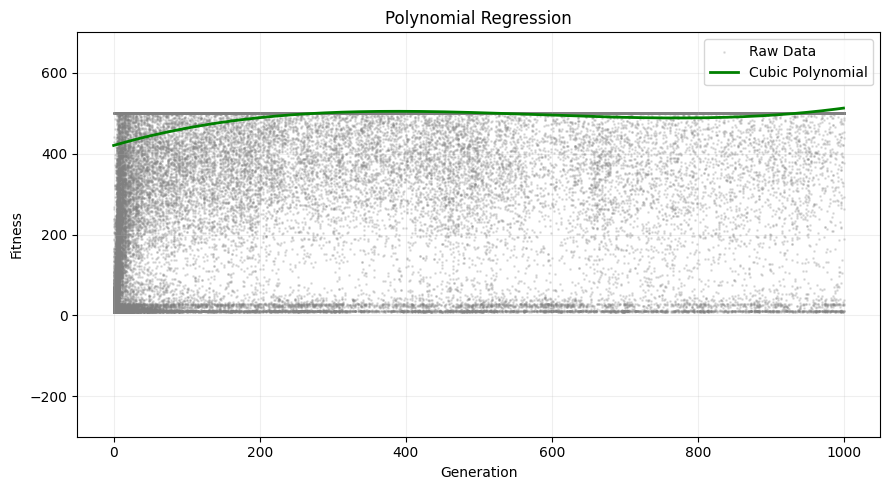

RL Training: 100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


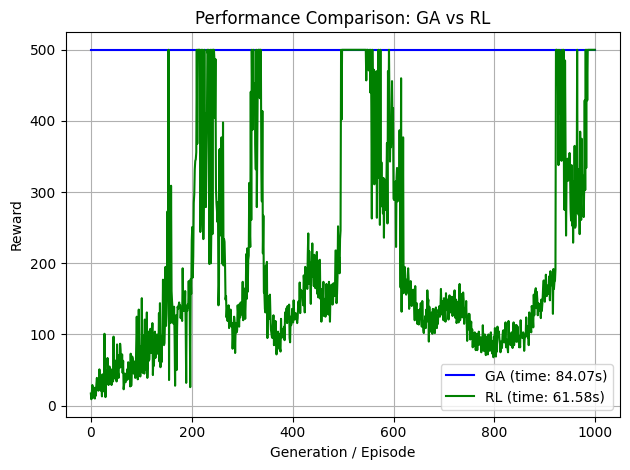

In [ ]:
if __name__ == "__main__":
    import time

    ga = GA(pop_size=1000, generations=1000)
    t0 = time.time()
    _, ga_history = ga.evolve()
    t1 = time.time()

    t2 = time.time()
    rl_history = train_rl(episodes=1000)
    t3 = time.time()

    plt.plot(ga_history, label=f"GA (time: {t1 - t0:.2f}s)", color='blue')
    plt.plot(rl_history, label=f"RL (time: {t3 - t2:.2f}s)", color='green')
    plt.xlabel("Generation / Episode")
    plt.ylabel("Reward")
    plt.title("Performance Comparison: GA vs RL")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

GA Evolving: 100%|██████████| 1000/1000 [01:22<00:00, 12.14it/s]


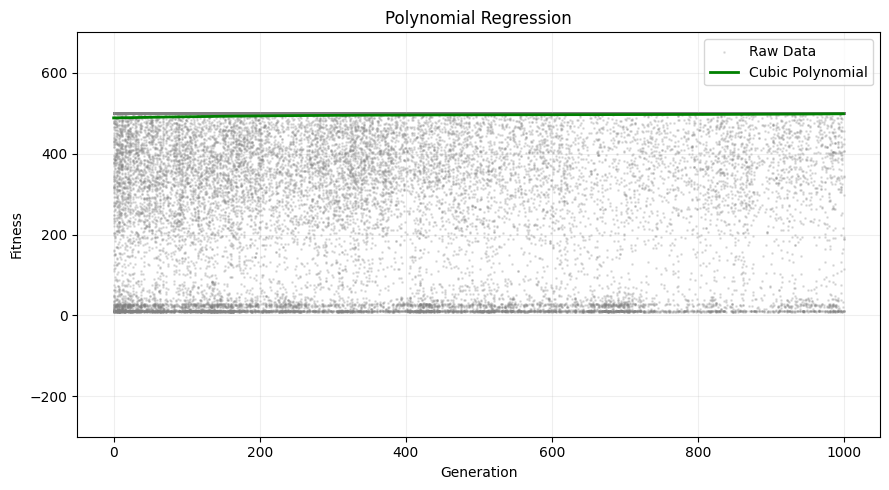

In [ ]:
best_genotype, _ = ga.evolve(num_workers=150)


In [ ]:
# ----------------- GA vs RL visualisation ------------------
from moviepy.editor import ImageSequenceClip
from IPython.display import Video, display
import cv2
import tempfile
import os

def decode_ga_action(genotype, obs):
    weights = genotype[:-2].reshape(2, 4)
    bias = genotype[-2:]
    logits = np.dot(weights, obs) + bias
    return np.argmax(logits)

def render_ga_vs_rl_video(best_genotype, rl_model, filename="ga_vs_rl.mp4", max_steps=500):
    env_ga = gym.make("CartPole-v1", render_mode="rgb_array")
    env_rl = gym.make("CartPole-v1", render_mode="rgb_array")

    obs_ga, _ = env_ga.reset()
    obs_rl, _ = env_rl.reset()

    frames = []

    for _ in range(max_steps):
        # GA Action
        action_ga = decode_ga_action(best_genotype, obs_ga)
        obs_ga, _, done_ga, trunc_ga, _ = env_ga.step(action_ga)
        frame_ga = env_ga.render()

        # RL Action
        obs_rl_tensor = torch.tensor(obs_rl, dtype=torch.float32)
        with torch.no_grad():
            logits = rl_model(obs_rl_tensor)
            action_rl = torch.argmax(logits).item()
        obs_rl, _, done_rl, trunc_rl, _ = env_rl.step(action_rl)
        frame_rl = env_rl.render()

        # Resize and concatenate
        frame_ga_resized = cv2.resize(frame_ga, (320, 240))
        frame_rl_resized = cv2.resize(frame_rl, (320, 240))
        combined = np.concatenate((frame_ga_resized, frame_rl_resized), axis=1)
        frames.append(combined[:, :, ::-1])  # Convert RGB to BGR for OpenCV

        if done_ga or trunc_ga or done_rl or trunc_rl:
            break

    env_ga.close()
    env_rl.close()

    # Save to MP4
    tmp_dir = tempfile.gettempdir()
    output_path = os.path.join(tmp_dir, filename)
    clip = ImageSequenceClip(frames, fps=30)
    clip.write_videofile(output_path, codec="libx264")

    # Display in notebook
    display(Video(output_path, embed=True))

In [ ]:
rl_model, _ = train_rl(episodes=1000)


RL Training: 100%|██████████| 1000/1000 [00:41<00:00, 24.24it/s]


In [ ]:
render_ga_vs_rl_video(best_genotype, rl_model)

Moviepy - Building video /tmp/ga_vs_rl.mp4.
Moviepy - Writing video /tmp/ga_vs_rl.mp4



Moviepy - Done !
Moviepy - video ready /tmp/ga_vs_rl.mp4
